on kaggle:
Intro to deep learning

Intro to computer vision

relu, selu, swish, elu

In [ ]:
#!pip install tensorflow
import tensorflow as tf
print(tf.__version__)

2.17.1


In [ ]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


NOTES FOR Project: do we want to run maximum pooling or conv2d

In [ ]:
#!pip install keras
path = '/content/drive/MyDrive/Tumor_Data/Dataset/Brain Tumor CT scan Images'
train_data = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=1122025,
    image_size=(224, 224), #complies with ResNet, EfficientNet
    batch_size=16,
    shuffle=True
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=1122025,
    image_size=(224, 224),
    batch_size=16,
    shuffle = True

)

Found 3274 files belonging to 2 classes.
Using 2620 files for training.
Found 3274 files belonging to 2 classes.
Using 654 files for validation.


In [ ]:
from keras import layers
from keras import layers

# Define preprocessing layers
rescale = layers.Rescaling(1./255)  # Normalize pixel values
flip = layers.RandomFlip('horizontal_and_vertical')  # Randomly flip images
rotate = layers.RandomRotation(0.2)  # Randomly rotate images

#Newly added preprocessing
carl_friedrich = layers.GaussianNoise(0.2)  # Add Gaussian noise to images
contrast = layers.RandomContrast(0.2)  # Randomly adjust contrast of images
zoom = layers.RandomZoom(0.2)  # Randomly zoom in on images

# Combine preprocessing layers in a Sequential model
data_augmentation = keras.Sequential([
    flip,
    rotate,
    rescale
])
def model_builder(alpha, activation, output_fn, optim, loss_fn):
  model = keras.Sequential([
      layers.InputLayer(input_shape=(224, 224, 3)),

      #Data Augmentation
      data_augmentation,

      #Block One
      layers.BatchNormalization(),
      layers.Conv2D(filters = 64, kernel_size = alpha, activation = activation, padding = 'same'),
      layers.MaxPool2D(),
      layers.Dropout(0.3), #Add to convolutional layers

      # Block Two
      layers.BatchNormalization(),
      layers.Conv2D(filters=128, kernel_size=alpha, activation=activation, padding='same'),
      layers.MaxPool2D(),
      layers.Dropout(0.3), #Add to convolutional layers

      # Block Three
      layers.BatchNormalization(),
      layers.Conv2D(filters=256, kernel_size=alpha, activation=activation, padding='same'),
      layers.Conv2D(filters=256, kernel_size=alpha, activation=activation, padding='same'),
      layers.MaxPool2D(),
      layers.Dropout(0.3), #Add to convolutional layers

      # Head
      layers.BatchNormalization(),
      layers.Flatten(),
      layers.Dense(8, activation=activation),
      layers.Dense(1, activation=output_fn),
  ])


  model.compile(
      optimizer = optim,
      loss = loss_fn,
      metrics = ['binary_accuracy'],
  )
  return model

Epoch 1/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1567s 10s/step - binary_accuracy: 0.8279 - loss: 0.5863 - val_binary_accuracy: 0.7263 - val_loss: 0.7564
Epoch 2/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1557s 9s/step - binary_accuracy: 0.8584 - loss: 0.3472 - val_binary_accuracy: 0.7278 - val_loss: 0.3846
Epoch 3/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1585s 9s/step - binary_accuracy: 0.8928 - loss: 0.2751 - val_binary_accuracy: 0.8670 - val_loss: 0.4029
Epoch 4/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1580s 9s/step - binary_accuracy: 0.9014 - loss: 0.2645 - val_binary_accuracy: 0.8609 - val_loss: 0.4770
Epoch 5/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1612s 10s/step - binary_accuracy: 0.9107 - loss: 0.2479 - val_binary_accuracy: 0.9037 - val_loss: 0.2584
Epoch 6/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1537s 9s/step - binary_accuracy: 0.9339 - loss: 0.1970 - val_binary_accuracy: 0.8991 - val_loss: 0.2521
Epoch 7/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1586s 9s/step - binary_accuracy: 0.9225 - loss: 0.2373 - val_binary_accuracy: 0.9373 - val_los

<Axes: >

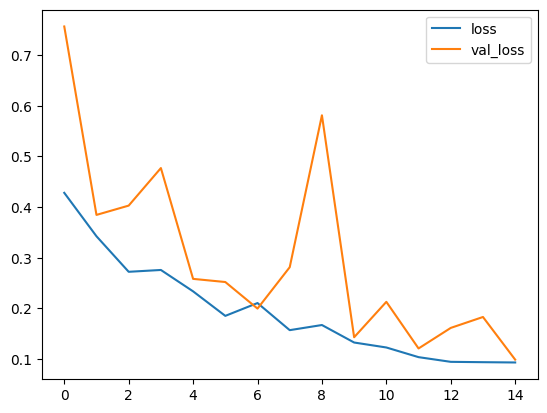

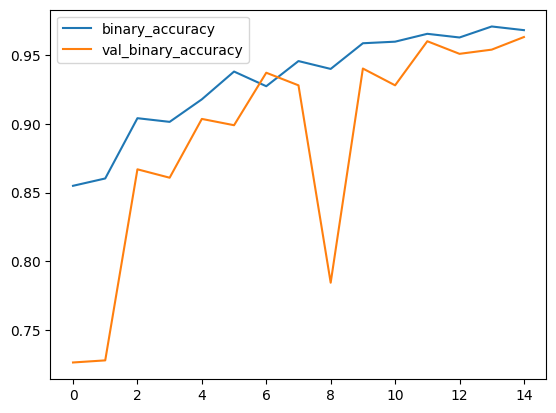

In [ ]:
#Fit model
model = model_builder(alpha = 3, activation = 'relu', output_fn = 'sigmoid',
                      optim = tf.keras.optimizers.Adam(epsilon=0.01),
                      loss_fn = 'binary_crossentropy')
history = model.fit(
      train_data,
      validation_data = validation_data,
      epochs = 15,
)

import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

Would like the curves here to be smoother: could add dropout with rate about .3.
Doesn't seem to be clear overfitting, but the lack of smoothness makes it harder to tell.
Best epoch was 15
The accuracy vs. epoch curve is increasing: this is good


Things that I want you to work on:
Implement this almost synonymously using pytorch.
There are a ton of resources online for this and there is great documentation.

I will work on using already trained heads to work up to industry standard:
ResNet, EfficientNet, etc

We can worry about hyperparameter tuning after we do this: I have a feeling it will be easier in pytorch.

We NEED to think holistically about ct scans.
What preprocessing would we want?
How can tumors differ on ct scans?

These images are not high res; hence, adding gaussian noise would be very beneficial.
Flips, rotations, zooms, contrasts, would clearly be useful as well.

I may add some visualizations which will include the ct scan images before/after preprocessing.

After this project, we need to do classification with many more classes on a separate medical issue. We could do ASL classification, wound types, fracture types, etc.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

In [ ]:
preprocess_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20, interpolation=InterpolationMode.BILINEAR),
    transforms.RandomApply([transforms.GaussianBlur(3)], p = 0.5),
    transforms.RandomAdjustSharpness(0.2, p=0.5),
    transforms.RandomResizedCrop((224, 224), scale = (0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [ ]:
class CustomModel(nn.Module):
  def __init__(self, alpha, activation, output_fn):
    super(CustomModel, self).__init__()
    self.activation_fn = getattr(F, activation)

    self.block1 = nn.Sequential(
        nn.BatchNorm2d(3),
        nn.Conv2d(3, 64, kernel_size=alpha, padding='same'),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.3),
    )

    self.block2 = nn.Sequential(
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 128, kernel_size=alpha, padding='same'),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.3)
    )

    self.block3 = nn.Sequential(
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 256, kernel_size=alpha, padding='same'),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.3)
    )

    self.head = nn.Sequential(
        nn.BatchNorm2d(256 * 28 * 28),
        nn.Flatten(),
        nn.Linear(256 * 28 * 28, 8),
        nn.ReLU(),
        nn.Linear(8, 1),
        nn.Sigmoid() if output_fn == 'sigmoid' else nn.Identity(),
    )
  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.head(x)
    return x

def model_builder(alpha, activation, output_fn, optim_fn, loss_fn):
  model = CustomModel(alpha = alpha, activation = activation, output_fn = output_fn)

  optimizer = optim_fn(model.parameters())

  loss_function = loss_fn

  return model, optimizer, loss_function


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

path = '/content/drive/MyDrive/Tumor_Data/Dataset/Brain Tumor CT scan Images'

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        ])
}

# Load dataset using ImageFolder
dataset = datasets.ImageFolder(root=path, transform=data_transforms['train'])

# Split dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Apply validation transforms to validation dataset
val_dataset.dataset.transform = data_transforms['val']

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle=True, num_workers=16)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=16)




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
from torch import nn, optim
import pandas as pd
import matplotlib.pyplot as plt


model, optimizer, loss_function = model_builder(
    alpha=3,
    activation = 'relu',
    output_fn='sigmoid',
    optim_fn = lambda params: optim.Adam(params, eps=0.01),
    loss_fn=nn.BCELoss()
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# training Loop
epochs = 15
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
  # training phase
  model.train()
  train_loss = 0.0
  correct = 0
  total = 0

  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()

    outputs = model(inputs).squeeze()
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item() * inputs.size(0)
    predicted = (outputs > 0.5).float()
    correct += (predicted == labels).sum().item()
    total += labels.size(0)

  train_loss /= len(train_loader.dataset)
  train_accuracy = correct / total
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  model.eval()
  val_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs).squeeze()
      loss = loss_function(outputs, labels)

      val_loss += loss.item() * inputs.size(0)
      predicted = (outputs > 0.5).float()
      correct += (predicted == labels).sum().item()
      total += labels.size(0)

  val_loss /= len(val_loader.dataset)
  val_accuracy = correct / total
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)

  print(f"Epoch {epoch + 1}/{epochs} - "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} - "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

  history_frame = pd.DataFrame({
      'loss': train_losses,
      'val_loss': val_losses,
      'binary_accuracy': train_accuracies,
      'val_binary_accuracy': val_accuracies,
  })

  history_frame[['loss', 'val_loss']].plot(title="Loss")
  plt.show()

  history_frame[['loss', 'val_loss']].plot(title="Loss")
  plt.show()


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-18-ea34eb596d83>", line 16, in __getitem__
    x, y = self.keras_data[idx]
TypeError: '_PrefetchDataset' object is not subscriptable


Now that we have built simple, convolutional neural networks, let's use pretrained, research-backed bases for computer vision.

In [ ]:
from tensorflow import keras
from keras import layers, Sequential
from keras.applications import ResNet50

# Define preprocessing layers
rescale = layers.Rescaling(1./255)  # Normalize pixel values
flip = layers.RandomFlip('horizontal_and_vertical')  # Randomly flip images
rotate = layers.RandomRotation(0.2)  # Randomly rotate images

# Combine preprocessing layers with explicit input shape
data_augmentation = keras.Sequential([
    layers.Input(shape=(224, 224, 3)),  # Define the input shape here
    flip,
    rotate,
    rescale
])

# Load Pretrained ResNet50 Base
base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Define the model builder
def base_model_builder(base=base, alpha=3, activation='relu', output_fn='sigmoid', optim='adam', loss_fn='binary_crossentropy'):
    base.trainable = False  # Freeze the base model
    model = Sequential([
        data_augmentation,  # Data augmentation as the first layer
        base,  # Pretrained ResNet50 base
        layers.GlobalAveragePooling2D(),  # Pooling layer to reduce dimensions
        layers.Dense(1, activation=output_fn)  # Output layer for binary classification
    ])
    model.compile(
        optimizer=optim,
        loss=loss_fn,
        metrics=['binary_accuracy']
    )
    return model

# Build and Train the Model
model = base_model_builder()

history = model.fit(
    train_data,  # Replace with your training dataset
    validation_data=validation_data,  # Replace with your validation dataset
    epochs=15
)

# Plot Training History
import pandas as pd
import matplotlib.pyplot as plt

history_frame = pd.DataFrame(history.history)

# Plot Loss
history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.title('Loss Over Epochs')
plt.show()

# Plot Accuracy
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()
plt.title('Accuracy Over Epochs')
plt.show()




Epoch 1/15
 25/164 ━━━━━━━━━━━━━━━━━━━━ 8:15 4s/step - binary_accuracy: 0.5195 - loss: 0.7419

KeyboardInterrupt: 